<a href="https://colab.research.google.com/github/pleasurre/my-first-web-site/blob/main/AIP2_Lab_activity_10_RNN_20231358.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab Session 10: RNN

_This notebook refered https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb_

## Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:

import pandas as pd
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"


# Common imports
import numpy as np

# to make model plot
from tensorflow.keras.utils import plot_model

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)
keras.utils.set_random_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Some Useful Functions

## Functions for visualization

• plot_series()

is a function that plots sequential data and optionally a label and a predicted
value in a 2D plane.

In [2]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):

  if len(series.squeeze().shape) == 0:
    n_steps = 1
  else:
    n_steps = series.squeeze().shape[0]
  ahead = 1
  plt.plot(series.squeeze(), ".-", label='x')
  if y is not None:
    if len(y.squeeze().shape) == 0:
      ahead = 1
      plt.plot((np.arange(n_steps, n_steps + ahead)), y.squeeze(0), "bx", label='actual y', markersize=10)
    else:
      ahead = y.squeeze().shape[0]
      plt.plot((np.arange(n_steps, n_steps + ahead)), y.squeeze(), "bx-", label='actual y', markersize=10)
  if y_pred is not None:
    if len(y_pred.squeeze().shape) == 0:
      ahead = 1
      plt.plot((np.arange(n_steps, n_steps + ahead)), y_pred.squeeze(0), "ro", label="predicted y")
    else:
      ahead = y_pred.squeeze().shape[0]
      plt.plot((np.arange(n_steps, n_steps + ahead)), y_pred.squeeze(), "ro-", label="predicted y")
  plt.grid(True)
  if x_label:
    plt.xlabel(x_label, fontsize=16)
  if y_label:
    plt.ylabel(y_label, fontsize=16, rotation=0)
  # plt.hlines(0, 0, 100, linewidth=1)
  plt.axis([0, n_steps + ahead, None, None])
  plt.legend(fontsize=14)

• plot_learning_curves()

is a function that plots both training loss curve and validation loss
curve.

In [3]:
def plot_learning_curves(loss, val_loss):
  plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
  plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
  plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
  plt.axis([1, len(loss), None, None]) #epoch default 20: but you can revise
  plt.legend(fontsize=14)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.grid(True)

## Function for Dataset Generation

**generate_time_series()**

is a function that generates time-series data. Single time series data is
generated with two sin functions with different offset, frequency, and amplitude and noise. This
function returns a numpy array with shape of (batch_size, n_steps, 1)

In [4]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

We will generate 10000 sequences, each of which contains 50 + 10 values.

First 50 values will be used as input and last 10 will be used as GT values to be predicted.

(In the first exercise, only the first values of GT sequences will be used.
Full GT sequences will be used in Exercise 2.)

As the sequential data is generated, slice the data according to the ratio of **7:2:1** for train, validation, and test respectively.

In [5]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)

x_train = series[:7000, :n_steps,: ]
x_valid = series[7000:9000, :n_steps,: ]# fill here
x_test = series[9000:, :n_steps,: ]# fill here

y_train = series[:7000, n_steps:,0 ]# fill here
y_valid = series[7000:9000, n_steps:,0 ]# fill here
y_test = series[9000:, n_steps:,0 ]# fill here

y_train_short = series[:7000, n_steps]# fill here
y_valid_short = series[7000:9000, n_steps]# fill here
y_test_short = series[9000:, n_steps]# fill here

In [6]:
# Print and check the shape of each data
print(series.shape)
print(x_train.shape, y_test_short.shape)

(10000, 60, 1)
(7000, 50, 1) (1000, 1)


You can visualize generated sequences and compare full sequences and short sequences.

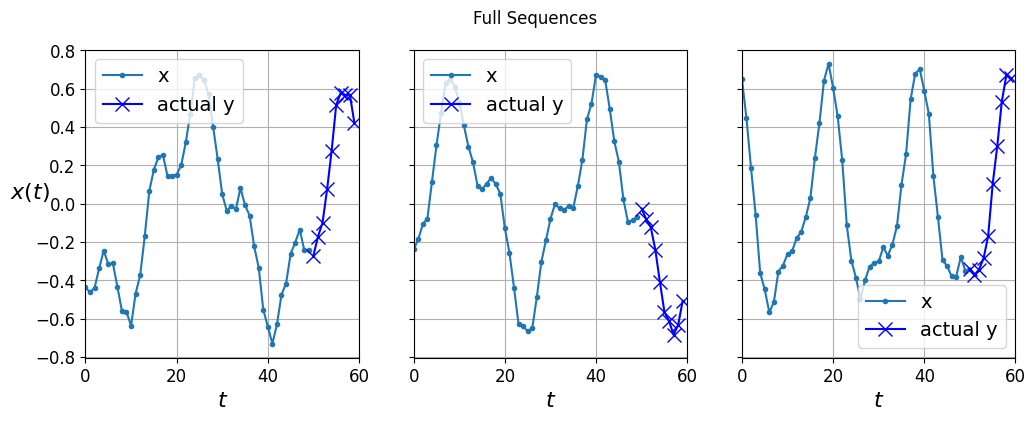

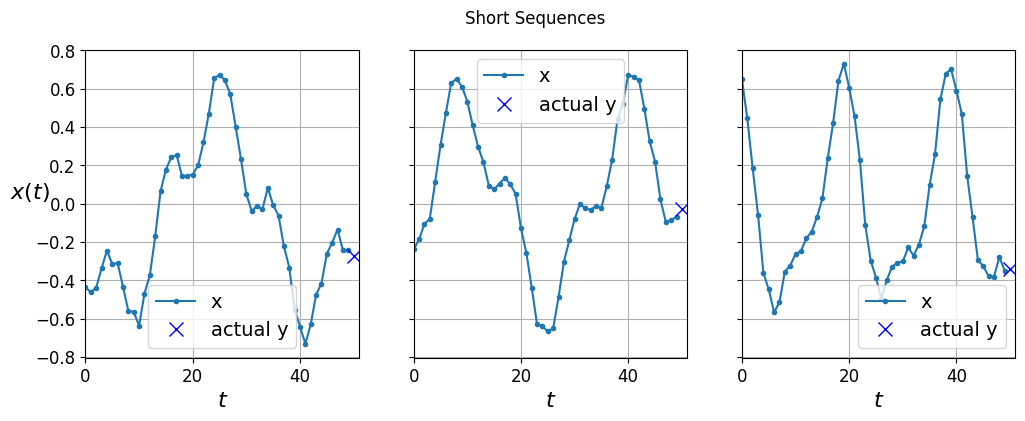

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(x_valid[col], y_valid[col],
                y_label=("$x(t)$" if col==0 else None))
plt.suptitle("Full Sequences")
plt.show()
plt.close()
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(x_valid[col], y_valid_short[col],
                y_label=("$x(t)$" if col==0 else None))
plt.suptitle("Short Sequences")
plt.show()
plt.close()

# Assignment 1: Implement everything from exercise

### Exercise 1: Forecasting One Step Ahead

Start with stacking some of the **SimpleRNN** and **Dense** cells to make a deep RNN.

Our model will have 2 **SimpleRNN** and 1 **Dense**.
Each layer will have 20, 20, and 1 nodes respectively.

What we need to do is to make a list of cells and pass the list to **keras.models.Sequential().**

Note the usage of **return_sequences**.

If return_sequence is True, the output of the SimpleRNN layer will be fed to next layer on every time stamp.
Unless, only the output on the last time stamp will be fed to the next layer.


The default value of return_sequence is False.

In [8]:
np.random.seed(42)
tf.random.set_seed(42)
keras.utils.set_random_seed(42)

rnn_dense = keras.models.Sequential([
    keras.layers.SimpleRNN(20,return_sequences=True, input_shape=[None,1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

rnn_dense.compile(
    loss='mse',optimizer='adam'
)
history = rnn_dense.fit(
    x_train,y_train_short,epochs=20,validation_data=(x_valid, y_valid_short)
)

Epoch 1/20
219/219 [==============================] - 10s 21ms/step - loss: 0.0187 - val_loss: 0.0037
Epoch 2/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 3/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 4/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 5/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 6/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 7/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 8/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 9/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0026 - val_l

In [9]:
rnn_dense.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, None, 20)          440       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20)                820       
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 1281 (5.00 KB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


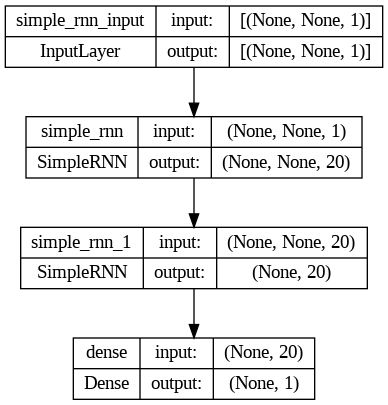

In [10]:
plot_model(rnn_dense, to_file='model_shapes.png', show_shapes=True)

In [11]:
rnn_dense.evaluate(x_test, y_test_short)

32/32 [==============================] - 0s 5ms/step - loss: 0.0029


0.0029410533607006073

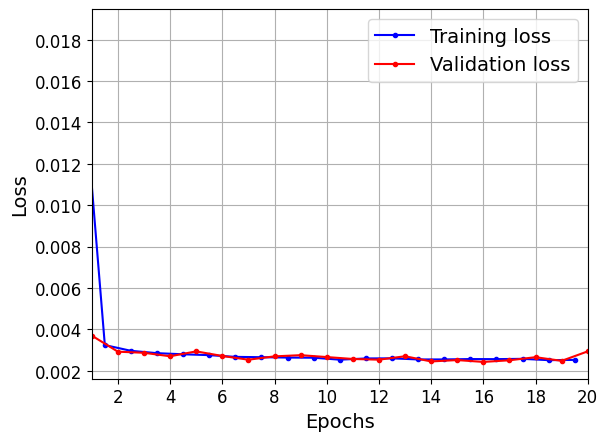

In [12]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

1/1 [==============================] - 0s 267ms/step


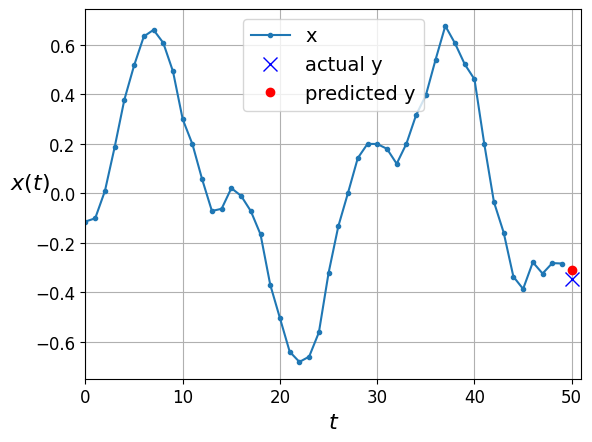

In [13]:
y_pred = rnn_dense.predict(x_test[None, 10])
plot_series(x_test[10], y_test_short[10], y_pred)
plt.show()

### Exercise 2: Forecasting Several Steps Ahead

We have trained models to predict only **one** step ahead.

Now, we will build and train models which can predict **multiple** steps ahead.
There are 3 possible approaches.

We will use y_train, y_valid, and y_test defined above.

#### **1st Approach: Iteratively run trained model**


The first approach is to reuse the above model by feeding a predicted value back to the model when we
use the model to predict the next value.


In the for loop below, the model predicts y value by propagating **X[:,step_ahead:(n_steps+step_ahead)]**

In order to save time, we will test only 10th index in the testset.

In [14]:
# Just take x_test[10] for this inference.
# make sure to maintain the original data.
x_iter = x_test[np.newaxis, 10].copy()

for step_ahead in range(10):
    print("x_iter's shape at iteration {}:".format(step_ahead),x_iter.shape, "| Index being used :","{} - {}".format(step_ahead,x_iter.shape[1]-1))
    y_pred_one=rnn_dense.predict(x_iter[:,step_ahead:step_ahead+n_steps])[:,np.newaxis,:]
    x_iter=np.concatenate([x_iter,y_pred_one],axis=1)

y_pred = x_iter[:, n_steps:]

x_iter's shape at iteration 0: (1, 50, 1) | Index being used : 0 - 49
1/1 [==============================] - 0s 32ms/step
x_iter's shape at iteration 1: (1, 51, 1) | Index being used : 1 - 50
1/1 [==============================] - 0s 21ms/step
x_iter's shape at iteration 2: (1, 52, 1) | Index being used : 2 - 51
1/1 [==============================] - 0s 27ms/step
x_iter's shape at iteration 3: (1, 53, 1) | Index being used : 3 - 52
1/1 [==============================] - 0s 22ms/step
x_iter's shape at iteration 4: (1, 54, 1) | Index being used : 4 - 53
1/1 [==============================] - 0s 25ms/step
x_iter's shape at iteration 5: (1, 55, 1) | Index being used : 5 - 54
1/1 [==============================] - 0s 26ms/step
x_iter's shape at iteration 6: (1, 56, 1) | Index being used : 6 - 55
1/1 [==============================] - 0s 23ms/step
x_iter's shape at iteration 7: (1, 57, 1) | Index being used : 7 - 56
1/1 [==============================] - 0s 26ms/step
x_iter's shape at iterat

Now plot the result from iterative inference above.

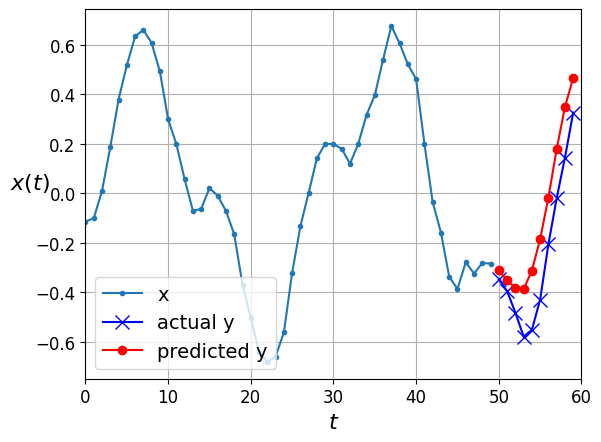

In [15]:
plot_series(x_test[10], y_test[10], y_pred)
plt.show()

#### **2nd Approach: Use Modified Dense Layer**

Second, we build a model to predict the values in the next 10 steps **at once.**

Before we start, let’s generate another time series data whose target is set of 10 y values, the 10 following steps after X.

It is ***easy*** to construct a model with more than one output value.

 If we **change the number of neurons in the Dense layer** in the **"rnn_dense" in Exercise 3**,

  we can build a similar model with a
different number of output values.

In [16]:
np.random.seed(42)
tf.random.set_seed(42)
keras.utils.set_random_seed(42)

rnn_ld = keras.models.Sequential([
    keras.layers.SimpleRNN(20,return_sequences=True, input_shape=[None,1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

rnn_ld.compile(
    loss='mse', optimizer='adam'
)

history = rnn_ld.fit(
    x_train,y_train,epochs=20,validation_data=(x_valid,y_valid)
)

Epoch 1/20
219/219 [==============================] - 10s 40ms/step - loss: 0.0611 - val_loss: 0.0308
Epoch 2/20
219/219 [==============================] - 9s 41ms/step - loss: 0.0241 - val_loss: 0.0177
Epoch 3/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0167 - val_loss: 0.0147
Epoch 4/20
219/219 [==============================] - 8s 37ms/step - loss: 0.0142 - val_loss: 0.0121
Epoch 5/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0123 - val_loss: 0.0106
Epoch 6/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0115 - val_loss: 0.0102
Epoch 7/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0106 - val_loss: 0.0111
Epoch 8/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0101 - val_loss: 0.0095
Epoch 9/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0100 - val_loss: 0.0108
Epoch 10/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0096 - val_l

In [17]:
rnn_ld.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 20)                820       
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
Total params: 1470 (5.74 KB)
Trainable params: 1470 (5.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
rnn_ld.evaluate(x_test, y_test)

32/32 [==============================] - 0s 6ms/step - loss: 0.0096


0.009635759517550468

In [19]:
print(y_test.shape)

(1000, 10)


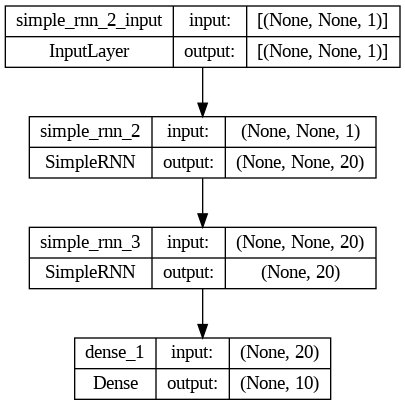

In [20]:
plot_model(rnn_ld, to_file='model_shapes.png', show_shapes=True)

In [21]:
y_pred = rnn_ld.predict(x_test[None, 10])

1/1 [==============================] - 0s 226ms/step


1/1 [==============================] - 0s 26ms/step


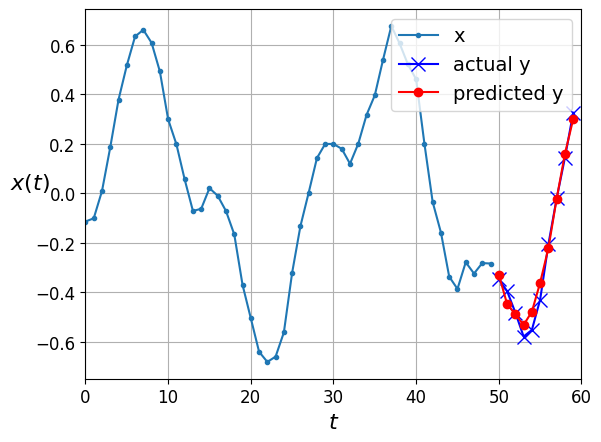

In [22]:
y_pred = rnn_ld.predict(x_test[np.newaxis, 10])
plot_series(x_test[10], y_test[10], y_pred)
plt.show()
plt.close()

#### **3rd Approach: Use TimeDistributed layer (Sequence to Sequence)**

Third, instead of building a model to predict the next 10 values **only at the very last time step**,
we can build a model to predict the next 10 values** at each and every time step.**



 We can have loss
terms from every output of each time step.
Instead of **having a sequence-to-vector RNN**, we now have **a sequence-to-sequence** RNN.

With sequence-to-sequence RNN, we can have many more gradients compared to sequence-to-vector
RNN during training stage.

For this reason, **training can be stabilized** and accelerated.




Before we start, let’s replace y with a single target value to the Y with 10 target values.

This will
make the model to generate predicted values for** time steps 1-10** at **time step 0**, and then generate
predicted values for **time steps 2-11** at **time step 1**, and so on.

Now let's reform original dataset to fit our new setting.

Previous setting required only one sequence per input sequence. (10000, 10)
Unlike that, new setting requires one sequence per elements in every input sequences. (10000, 50, 10)

So you should rearange sequences while shifting indices.

To build a sequence-to-sequence model, we must set **return_sequences=True** in all recurrent layers.


In following code, there is a special layer called **TimeDistributed layer.** We can wraps this special
layer around any layer (e.g., the Dense layer in the following code) so that the wrapped layer’s
operation can be **applied to every time step’s output.**


The TimeDistributed layer **enables the model to output a sequence of predicted** values in the next
10 time steps. The shape of the sequence is **(n_steps, 10).**

In [23]:
y_td = np.zeros((10000, n_steps, 10))
for i in range(10):
    y_td[:,:,i] = series[:,i+1:i+1+n_steps, 0]
y_train_td = y_td[:7000]
y_valid_td = y_td[7000:9000]
y_test_td = y_td[9000:]
print(y_train_td.shape, y_valid_td.shape, y_test_td.shape)

(7000, 50, 10) (2000, 50, 10) (1000, 50, 10)


and finally it will forecast **time steps 50** **to 59 at the last time step**. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [24]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [25]:
np.random.seed(42)
tf.random.set_seed(42)
keras.utils.set_random_seed(42)

rnn_td = keras.models.Sequential([
    keras.layers.SimpleRNN(20,return_sequences=True, input_shape=[None,1]),
    keras.layers.SimpleRNN(20,return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])


rnn_td.compile(
    loss='mse',optimizer='adam',metrics=[last_time_step_mse]
)

history = rnn_td.fit(
    x_train, y_train_td, epochs=20, validation_data=(x_valid, y_valid_td)
)

Epoch 1/20
219/219 [==============================] - 6s 21ms/step - loss: 0.0737 - last_time_step_mse: 0.0627 - val_loss: 0.0483 - val_last_time_step_mse: 0.0357
Epoch 2/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0438 - last_time_step_mse: 0.0299 - val_loss: 0.0398 - val_last_time_step_mse: 0.0262
Epoch 3/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0379 - last_time_step_mse: 0.0226 - val_loss: 0.0364 - val_last_time_step_mse: 0.0220
Epoch 4/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0358 - last_time_step_mse: 0.0204 - val_loss: 0.0344 - val_last_time_step_mse: 0.0189
Epoch 5/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0341 - last_time_step_mse: 0.0185 - val_loss: 0.0333 - val_last_time_step_mse: 0.0175
Epoch 6/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0335 - last_time_step_mse: 0.0184 - val_loss: 0.0325 - val_last_time_step_mse: 0.0168
Epoch 7/20
219/219 [==

In [26]:
rnn_td.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, None, 20)          820       
                                                                 
 time_distributed (TimeDist  (None, None, 10)          210       
 ributed)                                                        
                                                                 
Total params: 1470 (5.74 KB)
Trainable params: 1470 (5.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
rnn_td.evaluate(x_test, y_test_td)

32/32 [==============================] - 0s 6ms/step - loss: 0.0272 - last_time_step_mse: 0.0117


[0.027187347412109375, 0.011668529361486435]

1/1 [==============================] - 0s 230ms/step


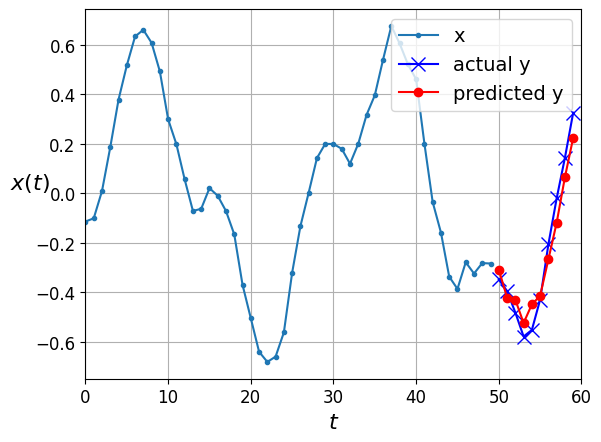

In [28]:
y_pred = rnn_td.predict(x_test[np.newaxis, 10])[:,-1]

plot_series(x_test[10], y_test[10], y_pred)
plt.show()

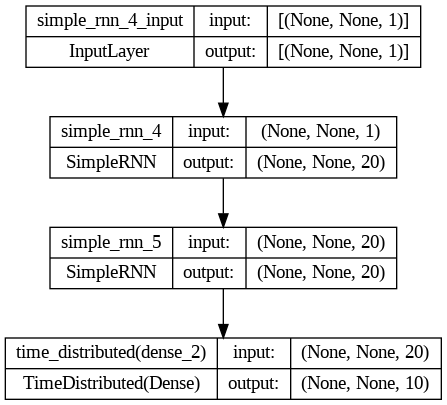

In [29]:
plot_model(rnn_td, to_file='model_shapes.png', show_shapes=True)

### Exercise 3: Temperature Forecast

Now you will predict daily temperature using real dataset.
Build model which can predict temperature of 2 days given values of 5 days.

Instructions:

* Download the climate dataset from the given URL in following code.

* Extract the temperature data in celsius.

* Train the model with the training set and the validation set.

* Evaluate the trained model with the test set.

* Check the error of your model using test set.

* The following code template uses a variable named y_pred to store the predicted y value.
Please stored the predicted y value in the y_pred variable.

#### Function for evaluation

Assignment 3 will be scored based on functions below.

In [30]:
def eval_temp_forecast(y_gt, y_pred):
    diff = np.abs(y_gt - y_pred)
    return diff.mean()

def vis_results(x, y_gt, y_pred, title=None):
    fig, axes = plt.subplots(nrows=3, ncols=4, sharey=True, figsize=(12, 8))
    for col, ax in enumerate(axes.flat[:len(y_gt)]):
        plt.sca(ax)
        plot_series(x[col], y_gt[col],y_pred[col],
                    y_label=None)
        plt.legend(fontsize=5)
    if title is not None:
        plt.suptitle(title)
    plt.show()
    plt.close()

In [31]:
# Load dataset from web
df = pd.read_csv("https://raw.githubusercontent.com/eepLearning/AIP2_RNN_LAB_Activity/main/Ulsan_Temp.csv")

In [32]:
print(df.tail(10))

           Date  Temperature(M)  Temperature(L)  Temperature(H)
754  2021-05-24            19.6            17.4            24.2
755  2021-05-25            19.0            13.9            24.3
756  2021-05-26            18.3            12.1            23.7
757  2021-05-27            19.1            14.9            24.4
758  2021-05-28            17.5            12.1            26.0
759  2021-05-29            19.3            12.1            25.9
760  2021-05-30            19.2            14.3            24.1
761  2021-05-31            19.0            15.2            25.1
762  2021-06-01            20.3            14.1            25.8
763  2021-06-02            20.9            17.5            26.3


#### Dataset Praparation

As you downloaded the dataset, you will **reshape** the dataset in unit of week (7 days).
And then, split the dataset as the ratio of 8:1:1 for train, validation, and test respectively.

In [33]:
# extract the temperature column and split the data in to 3 datasets: training set, validation set, test set.
n_steps_temp = 5
ahead = 2

temperature = (df['Temperature(H)'].values).copy()

temperature = temperature[:temperature.shape[0]//(n_steps_temp+ahead) * (n_steps_temp+ahead)].reshape(-1, (n_steps_temp+ahead))

i_valid= int(0.8*temperature.shape[0])
i_test= int(0.9*temperature.shape[0])

temp_train = temperature[:i_valid]
temp_valid = temperature[i_valid:i_test]
temp_test = temperature[i_test:]

x_train_t, y_train_t = temp_train[:, :5], temp_train[:,-2:]
x_valid_t, y_valid_t = temp_valid[:, :5], temp_valid[:,-2:]
x_test_t, y_test_t = temp_test[:, :5], temp_test[:,-2:]

In [34]:
print(x_train_t.shape, y_train_t.shape)

(87, 5) (87, 2)


#### Model Definition and Training

Build model for predicting daily temperature.
Your model will have 2 RNN layers and 2 Dense layers.
Each layer will have 20, 20, 10, and 2 nodes respectively.

In [35]:
np.random.seed(42)
tf.random.set_seed(42)
keras.utils.set_random_seed(42)

temp_model = keras.models.Sequential([
    keras.layers.SimpleRNN(20,return_sequences=True, input_shape=[None,1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10,activation='relu'),
    keras.layers.Dense(2)
])
temp_model.compile(
    loss='mse', optimizer='adam'
)

history = temp_model.fit(
    x_train_t, y_train_t, epochs=150, validation_data=(x_valid_t, y_valid_t)
)
y_pred = temp_model.predict(x_test_t)

Epoch 1/150
3/3 [==============================] - 2s 178ms/step - loss: 468.9839 - val_loss: 126.1579
Epoch 2/150
3/3 [==============================] - 0s 19ms/step - loss: 457.5384 - val_loss: 120.8345
Epoch 3/150
3/3 [==============================] - 0s 17ms/step - loss: 448.0070 - val_loss: 116.3172
Epoch 4/150
3/3 [==============================] - 0s 19ms/step - loss: 439.1316 - val_loss: 112.3512
Epoch 5/150
3/3 [==============================] - 0s 18ms/step - loss: 430.0751 - val_loss: 108.7761
Epoch 6/150
3/3 [==============================] - 0s 17ms/step - loss: 421.5874 - val_loss: 105.3656
Epoch 7/150
3/3 [==============================] - 0s 19ms/step - loss: 413.4399 - val_loss: 101.7606
Epoch 8/150
3/3 [==============================] - 0s 21ms/step - loss: 405.3387 - val_loss: 98.1836
Epoch 9/150
3/3 [==============================] - 0s 19ms/step - loss: 397.7414 - val_loss: 94.9086
Epoch 10/150
3/3 [==============================] - 0s 18ms/step - loss: 390.0061 -

Average error of the model: 3.4657636555758398


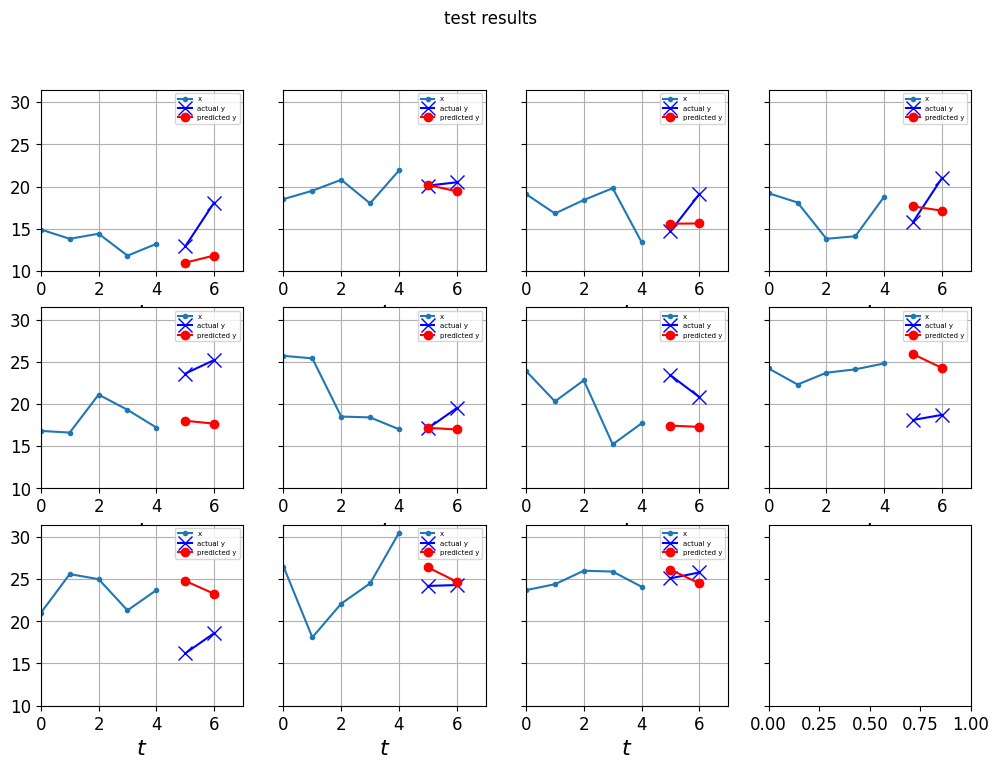

In [36]:
loss = eval_temp_forecast(y_test_t, y_pred)
print("Average error of the model:", loss)

vis_results(x_test_t, y_test_t, y_pred, "test results")

# Assignment 2: Re-implement codes in assignment 1 using LSTM and compare them

#### Forecast multiple step ahead using **TimeDistributed** LSTM and compare with **TimeDistributed** RNN
Build the model with **equal size** as multiple-step-prediction model that you made on exercise 1, but **replace RNN module with LSTM module**.

Then **compare** them in performance.
You should show the **loss** of them and **plot** the prediction results on **both**.

In [37]:
np.random.seed(42)
tf.random.set_seed(42)
keras.utils.set_random_seed(42)

lstm_td = keras.models.Sequential([
    keras.layers.LSTM(20,return_sequences=True, input_shape=[None,1]),
    keras.layers.LSTM(20,return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])


lstm_td.compile(
    loss='mse',optimizer='adam',metrics=[last_time_step_mse]
)

history = lstm_td.fit(
    x_train, y_train_td, epochs=20, validation_data=(x_valid, y_valid_td)
)

Epoch 1/20
219/219 [==============================] - 15s 52ms/step - loss: 0.0777 - last_time_step_mse: 0.0615 - val_loss: 0.0523 - val_last_time_step_mse: 0.0290
Epoch 2/20
219/219 [==============================] - 11s 49ms/step - loss: 0.0468 - last_time_step_mse: 0.0240 - val_loss: 0.0418 - val_last_time_step_mse: 0.0182
Epoch 3/20
219/219 [==============================] - 9s 39ms/step - loss: 0.0384 - last_time_step_mse: 0.0160 - val_loss: 0.0361 - val_last_time_step_mse: 0.0144
Epoch 4/20
219/219 [==============================] - 11s 48ms/step - loss: 0.0341 - last_time_step_mse: 0.0135 - val_loss: 0.0325 - val_last_time_step_mse: 0.0125
Epoch 5/20
219/219 [==============================] - 19s 85ms/step - loss: 0.0319 - last_time_step_mse: 0.0128 - val_loss: 0.0310 - val_last_time_step_mse: 0.0124
Epoch 6/20
219/219 [==============================] - 10s 48ms/step - loss: 0.0305 - last_time_step_mse: 0.0124 - val_loss: 0.0297 - val_last_time_step_mse: 0.0120
Epoch 7/20
219/21

##### Compare RNN based time distributed model and LSTM based time distributed model
You should include average loss and plot the prediction result on 10th index of testset.

1/1 [==============================] - 0s 153ms/step


1/1 [==============================] - 1s 1s/step
Error of RNN model: [0.027187347412109375, 0.011668529361486435]
Error of LSTM model: [0.02292618714272976, 0.007395385764539242]


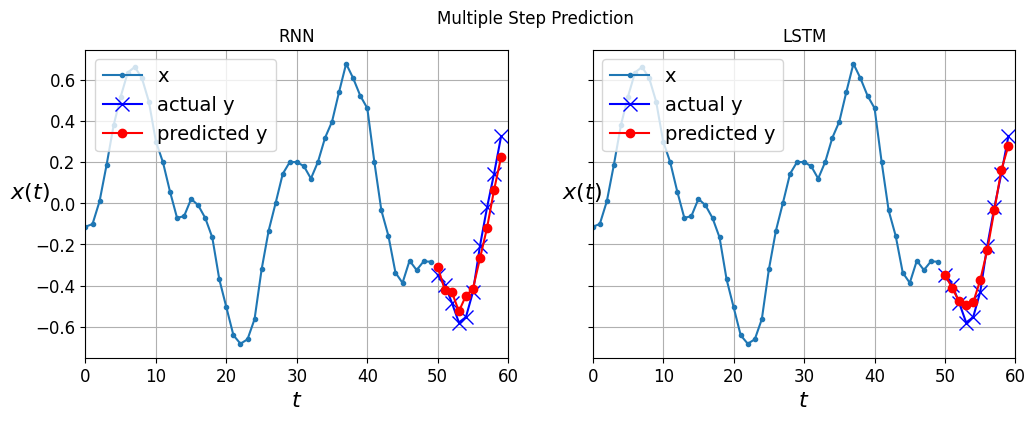

In [38]:
loss_rnn_td = rnn_td.evaluate(x_test, y_test_td)
loss_lstm_td = lstm_td.evaluate(x_test, y_test_td)
y_pred_rnn = rnn_td.predict(x_test[np.newaxis, 10])[:,-1]
y_pred = lstm_td.predict(x_test[np.newaxis, 10])[:,-1]
print("Error of RNN model:", loss_rnn_td)
print("Error of LSTM model:", loss_lstm_td)

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 4))
plt.sca(axes[0])
plot_series(x_test[10], y_test[10], y_pred_rnn)
plt.title("RNN")
plt.sca(axes[1])
plot_series(x_test[10], y_test[10], y_pred)
plt.title("LSTM")
plt.suptitle("Multiple Step Prediction")
plt.show()
plt.close()

### Temperature Forecast

Predict daily temperature using LSTM.

In [39]:
np.random.seed(42)
tf.random.set_seed(42)
keras.utils.set_random_seed(42)

temp_model_lstm = keras.models.Sequential([
    keras.layers.LSTM(20,return_sequences=True, input_shape=[None,1]),
    keras.layers.LSTM(20),
    keras.layers.Dense(10,activation='relu'),
    keras.layers.Dense(2)
])
temp_model_lstm.compile(
    loss='mse', optimizer='adam'
)

history = temp_model_lstm.fit(
    x_train_t, y_train_t, epochs=150, validation_data=(x_valid_t, y_valid_t)
)


Epoch 1/150
3/3 [==============================] - 5s 447ms/step - loss: 485.1133 - val_loss: 138.0158
Epoch 2/150
3/3 [==============================] - 0s 20ms/step - loss: 480.3939 - val_loss: 135.7446
Epoch 3/150
3/3 [==============================] - 0s 21ms/step - loss: 475.3676 - val_loss: 133.1932
Epoch 4/150
3/3 [==============================] - 0s 22ms/step - loss: 469.8993 - val_loss: 130.3119
Epoch 5/150
3/3 [==============================] - 0s 22ms/step - loss: 463.3882 - val_loss: 127.1107
Epoch 6/150
3/3 [==============================] - 0s 21ms/step - loss: 456.4880 - val_loss: 123.6612
Epoch 7/150
3/3 [==============================] - 0s 21ms/step - loss: 448.9917 - val_loss: 119.9781
Epoch 8/150
3/3 [==============================] - 0s 25ms/step - loss: 441.0468 - val_loss: 116.0501
Epoch 9/150
3/3 [==============================] - 0s 22ms/step - loss: 432.8307 - val_loss: 111.8699
Epoch 10/150
3/3 [==============================] - 0s 23ms/step - loss: 423.8762

In [40]:
y_pred = temp_model_lstm.predict(x_test_t)
y_pred_rnn = temp_model.predict(x_test_t)

1/1 [==============================] - 0s 91ms/step


Average error of RNN: 3.4657636555758398


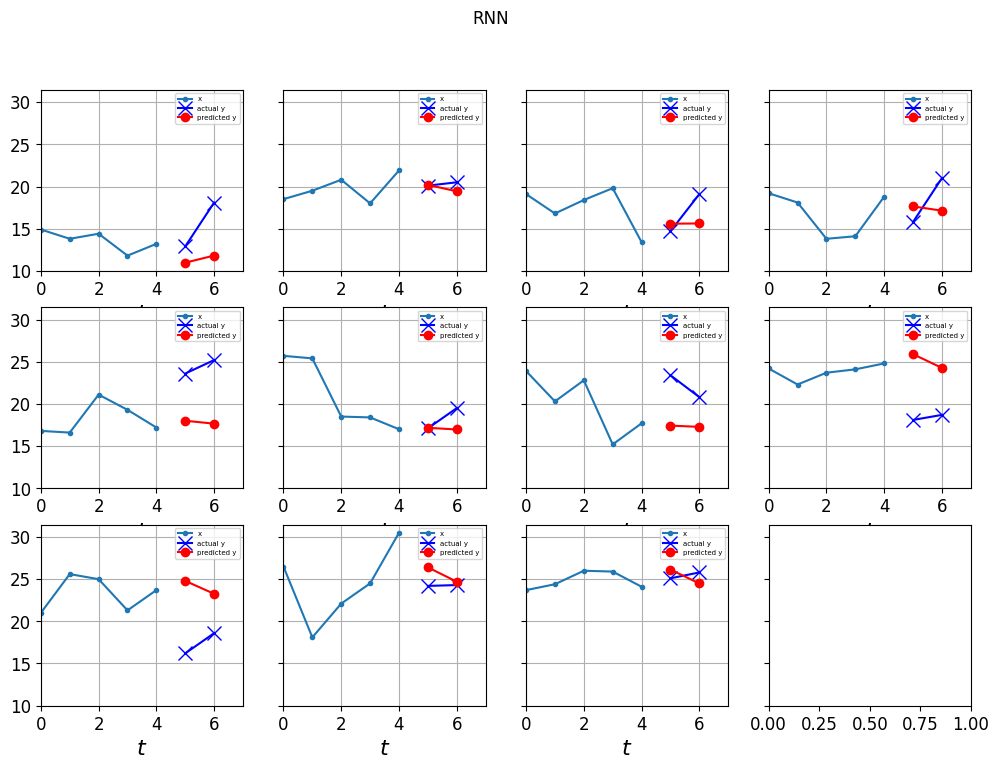

Average error of LSTM: 3.136727558482777


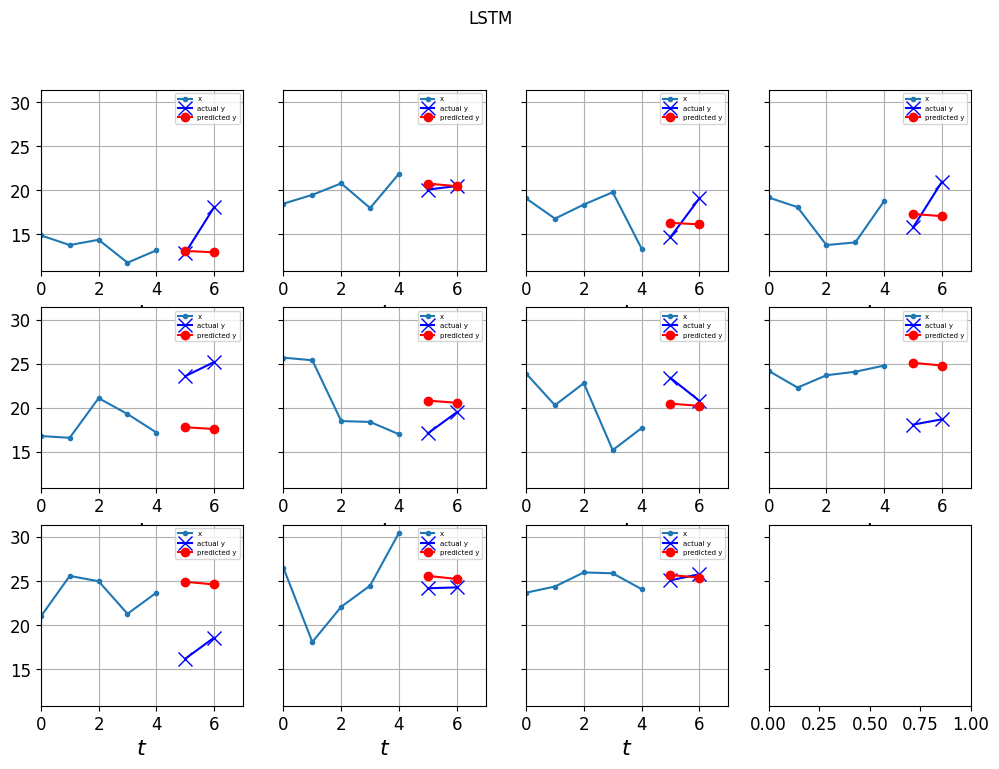

In [41]:
loss_lstm = eval_temp_forecast(y_test_t, y_pred)
loss_rnn = eval_temp_forecast(y_test_t, y_pred_rnn)
print("Average error of RNN:", loss_rnn)
vis_results(x_test_t, y_test_t, y_pred_rnn, "RNN")
print("Average error of LSTM:", loss_lstm)
vis_results(x_test_t, y_test_t, y_pred, "LSTM")

# Assignment 3: Build your own Prediction model for daily temperature

#### Model Definition and Training

Write your own model for predicting daily temperature.
You can design your model as you want.

Make sure that model is your own code and try to reduce the error.

To get full score, your model must have error less than 2.75

In [107]:
np.random.seed(42)
tf.random.set_seed(42)
keras.utils.set_random_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(40,return_sequences=True, input_shape=[None,1]),
    keras.layers.LSTM(20),
    tf.keras.layers.Dropout(0.2),
    keras.layers.Dense(60, activation='relu'),
    keras.layers.Normalization(),
    tf.keras.layers.Dropout(0.2),
    keras.layers.Dense(2),
    keras.layers.Normalization(),
])

model.compile(
    loss='mae', optimizer='adam'
)

history = model.fit(
    x_train_t, y_train_t, epochs=50, validation_data=(x_valid_t, y_valid_t)
)

y_pred = model.predict(x_test_t)

Epoch 1/50
3/3 [==============================] - 5s 442ms/step - loss: 20.6406 - val_loss: 10.3135
Epoch 2/50
3/3 [==============================] - 0s 23ms/step - loss: 20.4441 - val_loss: 10.1247
Epoch 3/50
3/3 [==============================] - 0s 27ms/step - loss: 20.2263 - val_loss: 9.9371
Epoch 4/50
3/3 [==============================] - 0s 23ms/step - loss: 20.0427 - val_loss: 9.7288
Epoch 5/50
3/3 [==============================] - 0s 23ms/step - loss: 19.7269 - val_loss: 9.4912
Epoch 6/50
3/3 [==============================] - 0s 22ms/step - loss: 19.4885 - val_loss: 9.2092
Epoch 7/50
3/3 [==============================] - 0s 22ms/step - loss: 19.1100 - val_loss: 8.8642
Epoch 8/50
3/3 [==============================] - 0s 23ms/step - loss: 18.8273 - val_loss: 8.4573
Epoch 9/50
3/3 [==============================] - 0s 23ms/step - loss: 18.3746 - val_loss: 7.9839
Epoch 10/50
3/3 [==============================] - 0s 25ms/step - loss: 17.8399 - val_loss: 7.4809
Epoch 11/50
3/3 

Average error of the model: 2.7159517288208006


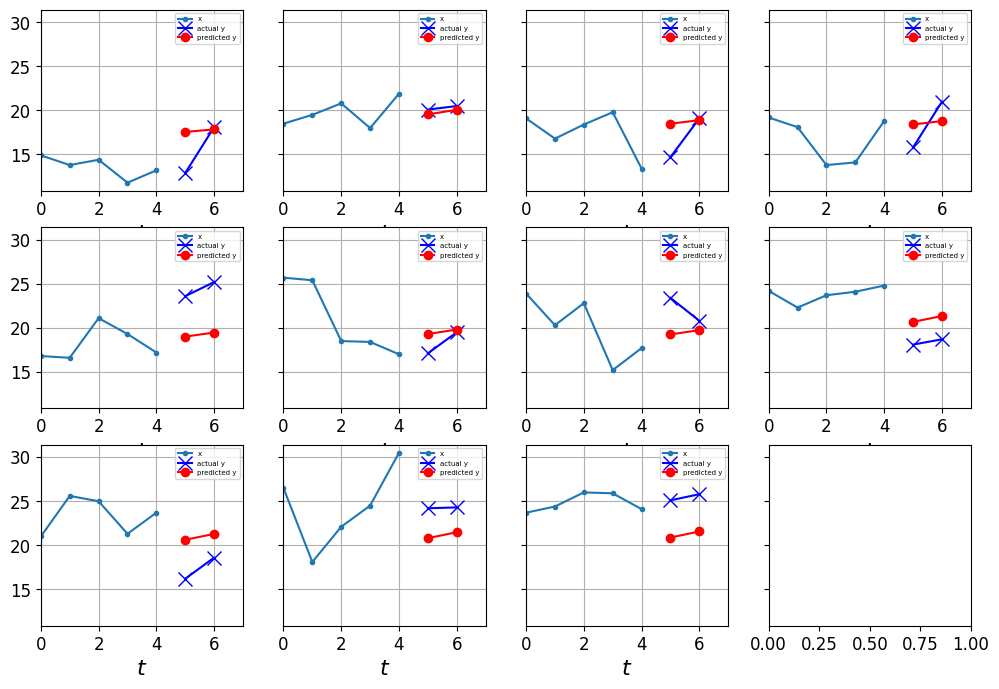

In [108]:
# Do not change this cell
loss = eval_temp_forecast(y_test_t, y_pred)
print("Average error of the model:", loss)

vis_results(x_test_t, y_test_t, y_pred)